# Volcano Plot

In [1]:
import sys
sys.path.append('..')
import os
from itertools import chain
from collections import defaultdict
import shelve
from tqdm import tqdm
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from adjustText import adjust_text

from scripts import utils
from scripts.analysis import build_loci
from scripts.analysis.DBInfo import DBInfo

BASE = '../data'
TYPE = '.svg'

db_info = DBInfo("compil_mgm")
metadata = pd.read_csv(os.path.join(BASE,"filt_metadata.csv"), index_col=0)

In [2]:
unenr_grouped_loci = utils.load(os.path.join(BASE,"unenriched_grouped_loci_adj.pkl.gz"))
enr_grouped_loci = utils.load(os.path.join(BASE,"enriched_grouped_loci_filt1_adj.pkl.gz"))

In [3]:
def plot_volcano(grouped_loci, fc_cutoff=4, p_val_cutoff=.05, labels=False, title='Volcano Plot', tax='both'):
    from adjustText import adjust_text
    import seaborn as sns
    
    sns.set_style('whitegrid')    
    
    if not tax in ['microbiome', 'mouse','both']:
        raise ValueError("Tax must be either 'microbiome', 'mouse', or 'both'")

    df = build_loci.get_sig_df(grouped_loci, fc_cutoff=fc_cutoff, p_val_cutoff=p_val_cutoff)
    annotations = build_loci.get_annotation_df(grouped_loci)
    df = df.merge(annotations, how='left')
    df['mouse_human'] = df['mouse_human'].astype('bool')
    df['sym'] = df['sym'].apply(lambda x: x if x != 'mgm' else '')
    #df['gene_name'] = df['name'].apply(build_loci.get_gene_name)
    #df['tax'] = df['lca'].dropna().apply(lambda x: t.taxid_to_taxonomy(x)['scientific_name'])
    
        
    X = df.query('~mouse_human')['logfc'].values
    Y = df.query('~mouse_human')['-logp'].values
    X1 = df.query('mouse_human')['logfc'].values
    Y1 = df.query('mouse_human')['-logp'].values

    fig = plt.figure(figsize=(10, 6))
    fig.set_tight_layout(False)

    if tax == 'microbiome':
        df = df.query('~mouse_human')
    elif tax == 'mouse':
        df = df.query('mouse_human')

    if tax in ['microbiome', 'both']:
        plt.scatter(X, Y, c = df.query('~mouse_human')['passes'], s=50, cmap='Paired', label='Microbiome')
    if tax in ['mouse', 'both']:    
        plt.scatter(X1, Y1, c = df.query('mouse_human')['passes'], s=50, marker = '^', cmap='Paired', label='Mouse')

    # Proteins mentioned in text to highlight
    highlight = ['Mug1', 'Pzp']
    highlight += df.loc[df['sym'].str.startswith('Serpin')]['sym'].tolist()
    highlight += df.loc[df['sym'].str.startswith('Reg')]['sym'].tolist()
    highlight += df.loc[df['sym'].str.startswith('Mptx')]['sym'].tolist()
    highlight += df.loc[df['sym'].str.startswith('Itln')]['sym'].tolist()
    highlight += df.loc[df['sym'].str.startswith('Defa')]['sym'].tolist()
    highlight += df.loc[df['sym'].str.startswith('S100a')]['sym'].tolist()
    highlight += df.loc[df['sym'].str.startswith('Mug')]['sym'].tolist()


    
    if labels and tax in ['microbiome', 'both']:
        texts = []
        for name, x, y in zip(df['sym'], df['logfc'].values, df['-logp'].values):
            if abs(x) > np.log2(fc_cutoff) and y > -1*np.log10(p_val_cutoff) and name == '': #and name in highlight:
                texts.append(plt.text(x, y, '*', size = 14, weight='extra bold'))
  
    if labels and tax in ['mouse', 'both']:
        texts = []
        for name, x, y in zip(df['sym'], df['logfc'].values, df['-logp'].values):
            if abs(x) > np.log2(fc_cutoff) and y > -1*np.log10(p_val_cutoff) and name != '' and name in highlight:
                texts.append(plt.text(x, y, name, size = 14, weight='extra bold'))
  
                
                
    # Titles and lables
    plt.title(title, size=24, y=1.02)
    plt.xlabel('log${}_{2}$ Fold Change', size=24)
    plt.ylabel('-log${}_{10}$ adj. p-value', size=24)
    plt.xticks(size=14)
    plt.yticks(size=14)
    
    if labels:
        adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
    plt.legend(title='Protein Source', loc=2, frameon=True, prop={'size': 14})
    
    # Plot asjustments
    axes = plt.gca()
    ylim = axes.get_ylim()
    xlim = axes.get_xlim()

    xlim = max(abs(xlim[0]), xlim[1])
    ylim = max(ylim[1], 2) # go up to at least 2
    
    plt.xlim(-1*xlim, xlim)
    plt.ylim(-0, ylim)
    
    if xlim <= 6:
        plt.xticks(range(-1*int(xlim), int(xlim)+1))
    
    # Draw significance lines
    h_line = -1*np.log10(p_val_cutoff)
    v_line = np.log2(fc_cutoff)
    plt.plot([v_line, v_line], [-0.2, ylim], lw=2, color='k', ls='--')
    plt.plot([-1*v_line, -1*v_line], [-0.2, ylim], lw=2, color='k', ls='--')
    plt.plot([-1*xlim, xlim], [h_line, h_line], lw=2, color='k', ls='--')

../scripts/analysis/build_loci/common.py:153: RuntimeWarning: divide by zero encountered in log10
  df['-logp'] = -1*np.log10(df['p_value'])


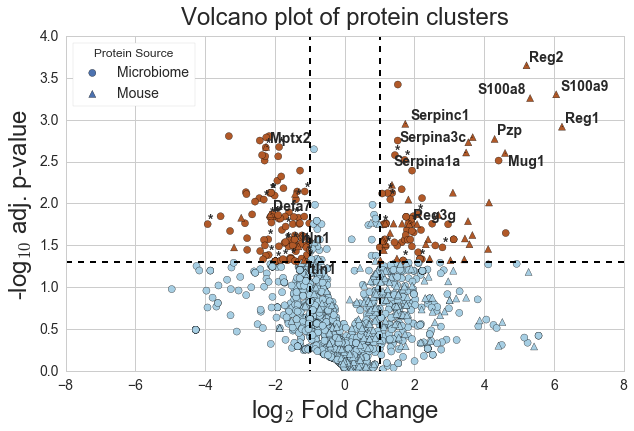

In [4]:
plot_volcano(unenr_grouped_loci, title='Volcano plot of protein clusters', fc_cutoff=2, p_val_cutoff=0.05, labels=True)
plt.savefig(os.path.join(BASE, 'volcano-unenriched'+TYPE))

../scripts/analysis/build_loci/common.py:153: RuntimeWarning: divide by zero encountered in log10
  df['-logp'] = -1*np.log10(df['p_value'])


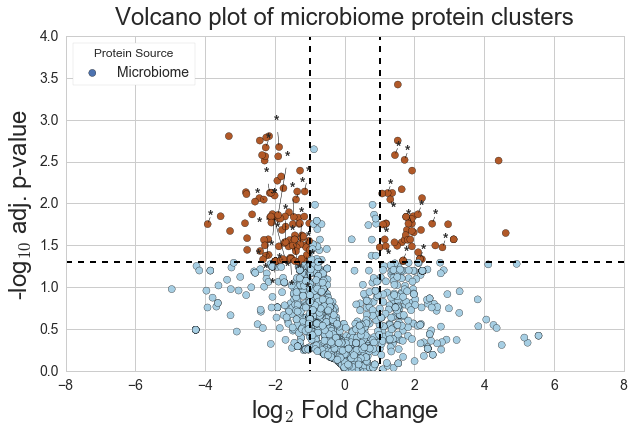

In [5]:
plot_volcano(unenr_grouped_loci, title='Volcano plot of microbiome protein clusters', fc_cutoff=2, p_val_cutoff=0.05, labels=True, tax='microbiome')
plt.savefig(os.path.join(BASE, 'volcano-unenriched-microbiome'+TYPE))

../scripts/analysis/build_loci/common.py:153: RuntimeWarning: divide by zero encountered in log10
  df['-logp'] = -1*np.log10(df['p_value'])


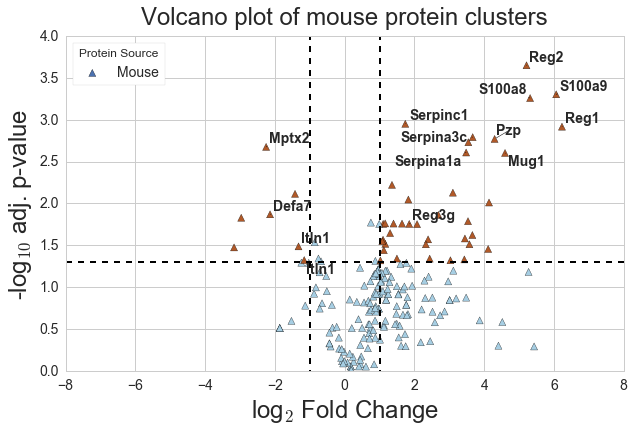

In [6]:
plot_volcano(unenr_grouped_loci, title='Volcano plot of mouse protein clusters', fc_cutoff=2, p_val_cutoff=0.05, labels=True, tax='mouse')
plt.savefig(os.path.join(BASE, 'volcano-unenriched-mouse'+TYPE))

../scripts/analysis/build_loci/common.py:153: RuntimeWarning: divide by zero encountered in log10
  df['-logp'] = -1*np.log10(df['p_value'])


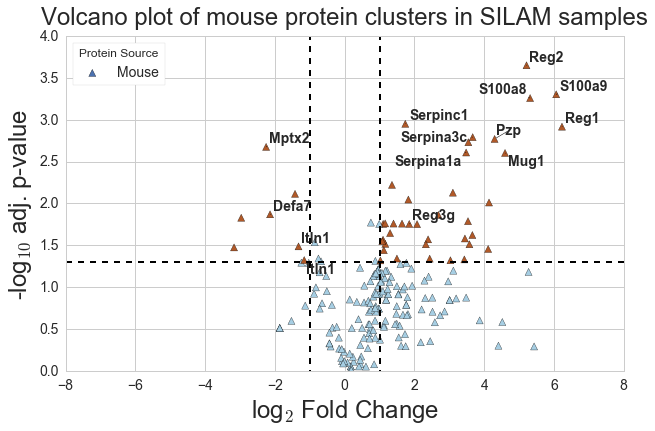

In [7]:
plot_volcano(unenr_grouped_loci, title='Volcano plot of mouse protein clusters in SILAM samples', fc_cutoff=2, p_val_cutoff=0.05, labels=True, tax='mouse')
plt.savefig(os.path.join(BASE, 'volcano-unenriched-mouse'+TYPE))

../scripts/analysis/build_loci/common.py:153: RuntimeWarning: divide by zero encountered in log10
  df['-logp'] = -1*np.log10(df['p_value'])


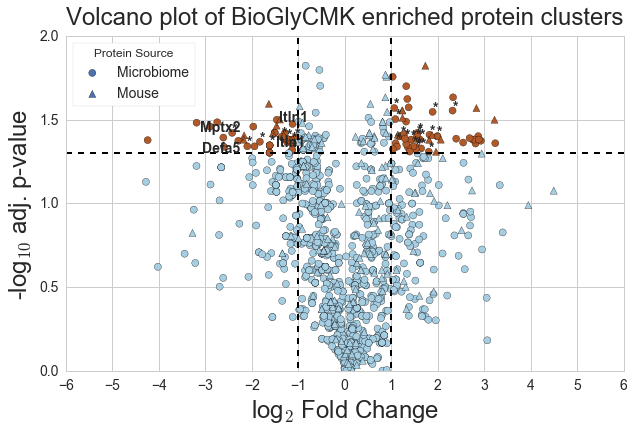

In [8]:
plot_volcano(enr_grouped_loci, title='Volcano plot of BioGlyCMK enriched protein clusters', fc_cutoff=2, p_val_cutoff=.05,labels=True)
plt.savefig(os.path.join(BASE, 'volcano-enriched'+TYPE))

../scripts/analysis/build_loci/common.py:153: RuntimeWarning: divide by zero encountered in log10
  df['-logp'] = -1*np.log10(df['p_value'])


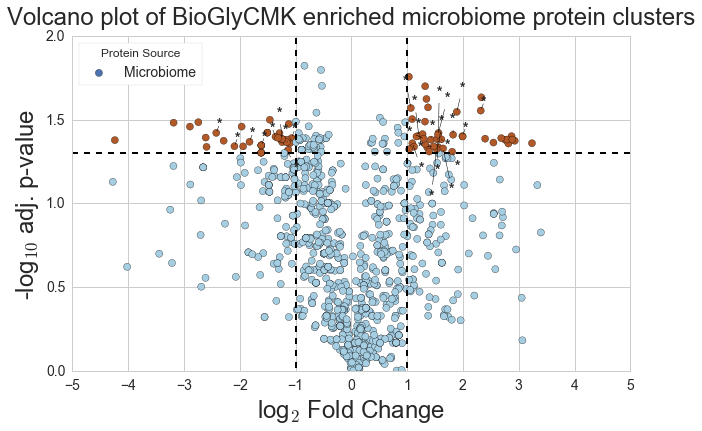

In [9]:
plot_volcano(enr_grouped_loci, title='Volcano plot of BioGlyCMK enriched microbiome protein clusters', fc_cutoff=2, p_val_cutoff=.05,labels=True, tax='microbiome')

plt.savefig(os.path.join(BASE, 'volcano-enriched-microbiome'+TYPE))

../scripts/analysis/build_loci/common.py:153: RuntimeWarning: divide by zero encountered in log10
  df['-logp'] = -1*np.log10(df['p_value'])


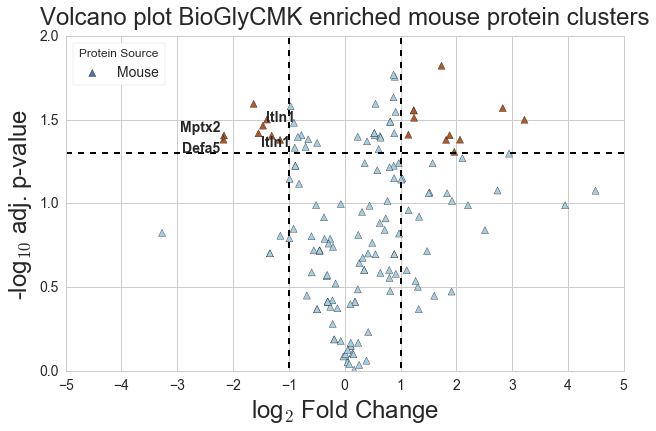

In [10]:
plot_volcano(enr_grouped_loci, title='Volcano plot BioGlyCMK enriched mouse protein clusters', fc_cutoff=2, p_val_cutoff=.05,labels=True, tax='mouse')

plt.savefig(os.path.join(BASE, 'volcano-enriched-mouse'+TYPE))